**Further train DeepCell Models with K's Data and Make Predictions**<br>
Starting from model trained with tn nuclear data, further train the model with resized K's data that is cut into 25x7 512x512 patches. There are a total of 12,574 training instances.<br>
200 epochs, semanticdatagenerator, resized<br>
Best mAP 0.48 at mpp=1.3

In [1]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
INPUT_PATH="images/training_resized_512x512/"
model_name = 'tn1.0_nuclear_K_512x512resized' 
model_path = '{}.h5'.format(model_name)
epochs=200 # 20 sec per step 

In [2]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os
from skimage import img_as_ubyte

import deepcell
from deepcell import image_generators
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell_toolbox.utils import resize, tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [3]:
import glob
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))
print(FILENAMES)

175
['images/training_resized_512x512/M872956_JML_Position8_CD8_train21_img.png', 'images/training_resized_512x512/M872956_JML_Position10_CD3_train13_img.png', 'images/training_resized_512x512/M872956_JML_Position9_CD3_train20_img.png', 'images/training_resized_512x512/M872956_JML_Position8_CD8_train6_img.png', 'images/training_resized_512x512/M926910_CFL_Position7_CD3_train24_img.png', 'images/training_resized_512x512/M926910_CFL_Position7_CD3_train4_img.png', 'images/training_resized_512x512/M872956_JML_Position8_CD3_train1_img.png', 'images/training_resized_512x512/M872956_JML_Position10_CD3_train21_img.png', 'images/training_resized_512x512/M872956_JML_Position8_CD8_train17_img.png', 'images/training_resized_512x512/M872956_JML_Position9_CD3_train15_img.png', 'images/training_resized_512x512/M872956_JML_Position10_CD3_train7_img.png', 'images/training_resized_512x512/M926910_CFL_Position7_CD3_train5_img.png', 'images/training_resized_512x512/M872956_JML_Position10_CD3_train1_img.pn

In [4]:
imgs = [io.imread(CURR_IM_NAME) for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

2022-11-18 18:32:23.403464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-18 18:32:23.405196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-18 18:32:23.406368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


(175, 512, 512, 1)
(175, 512, 512, 1)


In [5]:
np.max(masks) # sanity check

2688

In [6]:
# create dataloader
seed=0
min_objects = 5

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.CroppingDataGenerator()

batch_size = 4 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

306615


In [7]:
mask_cnt=[len(np.unique(x)) for x in masks]
print(np.sort(mask_cnt))
indices = [mask_cnt.index(1)]
indices.extend([i for i, x in enumerate(mask_cnt) if x == 1])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 2])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 4])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 6])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 7])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 10])
print(indices)

[  1   2   2   2   4   4   6   6   7   7   7   7  10  10  10  11  11  12
  14  15  16  18  19  19  20  20  21  24  25  25  26  27  27  28  30  31
  32  33  35  37  37  39  39  40  43  44  44  46  47  47  47  47  50  50
  52  53  53  53  54  54  54  55  55  58  59  61  61  61  63  65  65  65
  67  67  69  69  70  70  72  73  74  75  75  75  75  76  78  78  79  83
  85  85  89  91  92  95  96  97  99  99  99  99 100 101 101 102 103 103
 104 104 105 105 106 108 108 108 108 109 111 111 116 116 117 117 119 121
 122 122 124 125 126 127 129 129 131 131 131 131 132 133 134 134 142 144
 146 146 151 153 154 155 156 162 162 164 165 169 170 172 172 174 175 181
 185 188 188 189 190 198 203 204 206 212 218 225 235]
[143, 143, 42, 120, 151, 67, 128, 18, 136, 63, 89, 137, 159, 68, 114, 145]


In [8]:
[FILENAMES[x] for x in indices]

['images/training_resized_512x512/M872956_JML_Position8_CD8_train14_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train14_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train9_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD3_train14_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train4_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train3_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD4_train4_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD3_train9_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD4_train9_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD4_train14_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train8_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train19_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train13_img

images/training_resized_512x512/M872956_JML_Position10_CD3_train0_img.png


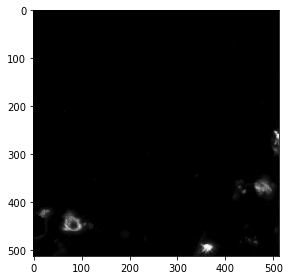

/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


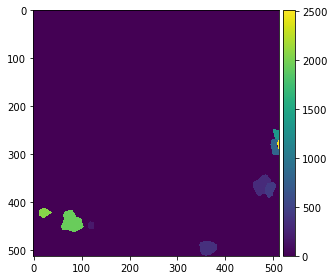

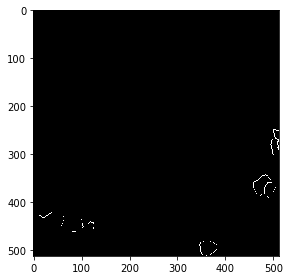

[   0  173  309  349  424  820 1353 1938 2054 2512]
[   0  173  309  349  424  820 1353 1938 2054 2512]


In [9]:
i=145
print(FILENAMES[i])
# plt.subplot(1, 3, 1) 
io.imshow(io.imread(FILENAMES[i]))
plt.show()
# plt.subplot(1, 3, 2) 
io.imshow(io.imread(FILENAMES[i].replace("_img","_masks")))
plt.show()
# plt.subplot(1, 3, 3) 
tmp=syotil.masks_to_outlines(io.imread(FILENAMES[i].replace("_img","_masks")))
io.imshow(tmp)
plt.show()
print(np.unique(masks[i]))
print(np.unique(masks[i][1:510,1:510]))

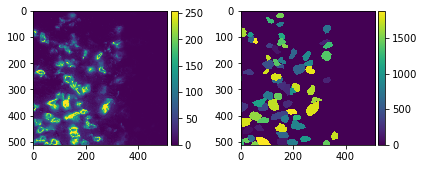

In [10]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [16]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=(512,512,1),
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[('semantic_0', (None, 512, 512, 1)),
 ('semantic_1', (None, 512, 512, 1)),
 ('semantic_2', (None, 512, 512, 2))]

In [17]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    # monitor='loss', # training loss
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size, # 
    epochs=epochs, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

Training on 3 GPUs.


2022-11-18 18:38:49.321390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-18 18:38:49.322501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-18 18:38:49.323595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/200
42/42 [==============================] - ETA: 0s - loss: 0.0163 - semantic_0_loss: 0.0041 - semantic_1_loss: 0.0102 - semantic_2_loss: 0.0020WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 48s 644ms/step - loss: 0.0163 - semantic_0_loss: 0.0041 - semantic_1_loss: 0.0102 - semantic_2_loss: 0.0020 - lr: 1.0000e-04
Epoch 2/200
42/42 [==============================] - ETA: 0s - loss: 0.0145 - semantic_0_loss: 0.0037 - semantic_1_loss: 0.0093 - semantic_2_loss: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0145 - semantic_0_loss: 0.0037 - semantic_1_loss: 0.0093 - semantic_2_loss: 0.0016 - lr: 9.9000e-05
Epoch 3/200
42/42 [==============================] - ETA: 0s - loss: 0.0141 - semantic_0_loss: 0.0036 - semantic_1_loss: 0.0090 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 560ms/step - loss: 0.0141 - semantic_0_loss: 0.0036 - semantic_1_loss: 0.0090 - semantic_2_loss: 0.0015 - lr: 9.8010e-05
Epoch 4/200
42/42 [==============================] - ETA: 0s - loss: 0.0136 - semantic_0_loss: 0.0035 - semantic_1_loss: 0.0086 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0136 - semantic_0_loss: 0.0035 - semantic_1_loss: 0.0086 - semantic_2_loss: 0.0015 - lr: 9.7030e-05
Epoch 5/200
42/42 [==============================] - ETA: 0s - loss: 0.0139 - semantic_0_loss: 0.0036 - semantic_1_loss: 0.0088 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 563ms/step - loss: 0.0139 - semantic_0_loss: 0.0036 - semantic_1_loss: 0.0088 - semantic_2_loss: 0.0015 - lr: 9.6060e-05
Epoch 6/200
42/42 [==============================] - ETA: 0s - loss: 0.0136 - semantic_0_loss: 0.0035 - semantic_1_loss: 0.0086 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 555ms/step - loss: 0.0136 - semantic_0_loss: 0.0035 - semantic_1_loss: 0.0086 - semantic_2_loss: 0.0015 - lr: 9.5099e-05
Epoch 7/200
42/42 [==============================] - ETA: 0s - loss: 0.0139 - semantic_0_loss: 0.0035 - semantic_1_loss: 0.0089 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0139 - semantic_0_loss: 0.0035 - semantic_1_loss: 0.0089 - semantic_2_loss: 0.0015 - lr: 9.4148e-05
Epoch 8/200
42/42 [==============================] - ETA: 0s - loss: 0.0136 - semantic_0_loss: 0.0035 - semantic_1_loss: 0.0087 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 563ms/step - loss: 0.0136 - semantic_0_loss: 0.0035 - semantic_1_loss: 0.0087 - semantic_2_loss: 0.0015 - lr: 9.3207e-05
Epoch 9/200
42/42 [==============================] - ETA: 0s - loss: 0.0134 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0085 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0134 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0085 - semantic_2_loss: 0.0015 - lr: 9.2274e-05
Epoch 10/200
42/42 [==============================] - ETA: 0s - loss: 0.0133 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0085 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 572ms/step - loss: 0.0133 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0085 - semantic_2_loss: 0.0015 - lr: 9.1352e-05
Epoch 11/200
42/42 [==============================] - ETA: 0s - loss: 0.0134 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0085 - semantic_2_loss: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 557ms/step - loss: 0.0134 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0085 - semantic_2_loss: 0.0015 - lr: 9.0438e-05
Epoch 12/200
42/42 [==============================] - ETA: 0s - loss: 0.0130 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0082 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 25s 587ms/step - loss: 0.0130 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0082 - semantic_2_loss: 0.0014 - lr: 8.9534e-05
Epoch 13/200
42/42 [==============================] - ETA: 0s - loss: 0.0130 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0082 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0130 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0082 - semantic_2_loss: 0.0014 - lr: 8.8638e-05
Epoch 14/200
42/42 [==============================] - ETA: 0s - loss: 0.0131 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0083 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 565ms/step - loss: 0.0131 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0083 - semantic_2_loss: 0.0014 - lr: 8.7752e-05
Epoch 15/200
42/42 [==============================] - ETA: 0s - loss: 0.0132 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0084 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 563ms/step - loss: 0.0132 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0084 - semantic_2_loss: 0.0014 - lr: 8.6875e-05
Epoch 16/200
42/42 [==============================] - ETA: 0s - loss: 0.0133 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0084 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 560ms/step - loss: 0.0133 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0084 - semantic_2_loss: 0.0014 - lr: 8.6006e-05
Epoch 17/200
42/42 [==============================] - ETA: 0s - loss: 0.0129 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0081 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 563ms/step - loss: 0.0129 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0081 - semantic_2_loss: 0.0014 - lr: 8.5146e-05
Epoch 18/200
42/42 [==============================] - ETA: 0s - loss: 0.0127 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 565ms/step - loss: 0.0127 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014 - lr: 8.4294e-05
Epoch 19/200
42/42 [==============================] - ETA: 0s - loss: 0.0131 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0083 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 574ms/step - loss: 0.0131 - semantic_0_loss: 0.0034 - semantic_1_loss: 0.0083 - semantic_2_loss: 0.0014 - lr: 8.3451e-05
Epoch 20/200
42/42 [==============================] - ETA: 0s - loss: 0.0127 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 567ms/step - loss: 0.0127 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014 - lr: 8.2617e-05
Epoch 21/200
42/42 [==============================] - ETA: 0s - loss: 0.0129 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0082 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0129 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0082 - semantic_2_loss: 0.0014 - lr: 8.1791e-05
Epoch 22/200
42/42 [==============================] - ETA: 0s - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 564ms/step - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014 - lr: 8.0973e-05
Epoch 23/200
42/42 [==============================] - ETA: 0s - loss: 0.0128 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0081 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0128 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0081 - semantic_2_loss: 0.0014 - lr: 8.0163e-05
Epoch 24/200
42/42 [==============================] - ETA: 0s - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 557ms/step - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014 - lr: 7.9361e-05
Epoch 25/200
42/42 [==============================] - ETA: 0s - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 555ms/step - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014 - lr: 7.8568e-05
Epoch 26/200
42/42 [==============================] - ETA: 0s - loss: 0.0127 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 553ms/step - loss: 0.0127 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014 - lr: 7.7782e-05
Epoch 27/200
42/42 [==============================] - ETA: 0s - loss: 0.0127 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0127 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014 - lr: 7.7004e-05
Epoch 28/200
42/42 [==============================] - ETA: 0s - loss: 0.0125 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 572ms/step - loss: 0.0125 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014 - lr: 7.6234e-05
Epoch 29/200
42/42 [==============================] - ETA: 0s - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0080 - semantic_2_loss: 0.0014 - lr: 7.5472e-05
Epoch 30/200
42/42 [==============================] - ETA: 0s - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 560ms/step - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014 - lr: 7.4717e-05
Epoch 31/200
42/42 [==============================] - ETA: 0s - loss: 0.0125 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 557ms/step - loss: 0.0125 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014 - lr: 7.3970e-05
Epoch 32/200
42/42 [==============================] - ETA: 0s - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0126 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014 - lr: 7.3230e-05
Epoch 33/200
42/42 [==============================] - ETA: 0s - loss: 0.0123 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0078 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0123 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0078 - semantic_2_loss: 0.0013 - lr: 7.2498e-05
Epoch 34/200
42/42 [==============================] - ETA: 0s - loss: 0.0125 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 562ms/step - loss: 0.0125 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0079 - semantic_2_loss: 0.0014 - lr: 7.1773e-05
Epoch 35/200
42/42 [==============================] - ETA: 0s - loss: 0.0123 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0078 - semantic_2_loss: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 571ms/step - loss: 0.0123 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0078 - semantic_2_loss: 0.0014 - lr: 7.1055e-05
Epoch 36/200
42/42 [==============================] - ETA: 0s - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 554ms/step - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013 - lr: 7.0345e-05
Epoch 37/200
42/42 [==============================] - ETA: 0s - loss: 0.0124 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0078 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0124 - semantic_0_loss: 0.0033 - semantic_1_loss: 0.0078 - semantic_2_loss: 0.0013 - lr: 6.9641e-05
Epoch 38/200
42/42 [==============================] - ETA: 0s - loss: 0.0121 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0121 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013 - lr: 6.8945e-05
Epoch 39/200
42/42 [==============================] - ETA: 0s - loss: 0.0121 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0121 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013 - lr: 6.8255e-05
Epoch 40/200
42/42 [==============================] - ETA: 0s - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013 - lr: 6.7573e-05
Epoch 41/200
42/42 [==============================] - ETA: 0s - loss: 0.0123 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0123 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013 - lr: 6.6897e-05
Epoch 42/200
42/42 [==============================] - ETA: 0s - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 557ms/step - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013 - lr: 6.6228e-05
Epoch 43/200
42/42 [==============================] - ETA: 0s - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 566ms/step - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013 - lr: 6.5566e-05
Epoch 44/200
42/42 [==============================] - ETA: 0s - loss: 0.0121 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0121 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013 - lr: 6.4910e-05
Epoch 45/200
42/42 [==============================] - ETA: 0s - loss: 0.0123 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 571ms/step - loss: 0.0123 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013 - lr: 6.4261e-05
Epoch 46/200
42/42 [==============================] - ETA: 0s - loss: 0.0117 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 557ms/step - loss: 0.0117 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013 - lr: 6.3619e-05
Epoch 47/200
42/42 [==============================] - ETA: 0s - loss: 0.0121 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0121 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013 - lr: 6.2982e-05
Epoch 48/200
42/42 [==============================] - ETA: 0s - loss: 0.0121 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 571ms/step - loss: 0.0121 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0076 - semantic_2_loss: 0.0013 - lr: 6.2353e-05
Epoch 49/200
42/42 [==============================] - ETA: 0s - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 569ms/step - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013 - lr: 6.1729e-05
Epoch 50/200
42/42 [==============================] - ETA: 0s - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013 - lr: 6.1112e-05
Epoch 51/200
42/42 [==============================] - ETA: 0s - loss: 0.0119 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0119 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013 - lr: 6.0501e-05
Epoch 52/200
42/42 [==============================] - ETA: 0s - loss: 0.0119 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0075 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0119 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0075 - semantic_2_loss: 0.0013 - lr: 5.9896e-05
Epoch 53/200
42/42 [==============================] - ETA: 0s - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 551ms/step - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013 - lr: 5.9297e-05
Epoch 54/200
42/42 [==============================] - ETA: 0s - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 568ms/step - loss: 0.0122 - semantic_0_loss: 0.0032 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0013 - lr: 5.8704e-05
Epoch 55/200
42/42 [==============================] - ETA: 0s - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 564ms/step - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013 - lr: 5.8117e-05
Epoch 56/200
42/42 [==============================] - ETA: 0s - loss: 0.0117 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0117 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013 - lr: 5.7535e-05
Epoch 57/200
42/42 [==============================] - ETA: 0s - loss: 0.0117 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 564ms/step - loss: 0.0117 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013 - lr: 5.6960e-05
Epoch 58/200
42/42 [==============================] - ETA: 0s - loss: 0.0116 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0116 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013 - lr: 5.6391e-05
Epoch 59/200
42/42 [==============================] - ETA: 0s - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013 - lr: 5.5827e-05
Epoch 60/200
42/42 [==============================] - ETA: 0s - loss: 0.0116 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 554ms/step - loss: 0.0116 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013 - lr: 5.5268e-05
Epoch 61/200
42/42 [==============================] - ETA: 0s - loss: 0.0117 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0117 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013 - lr: 5.4716e-05
Epoch 62/200
42/42 [==============================] - ETA: 0s - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 560ms/step - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013 - lr: 5.4169e-05
Epoch 63/200
42/42 [==============================] - ETA: 0s - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013 - lr: 5.3627e-05
Epoch 64/200
42/42 [==============================] - ETA: 0s - loss: 0.0115 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0115 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013 - lr: 5.3091e-05
Epoch 65/200
42/42 [==============================] - ETA: 0s - loss: 0.0114 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0114 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013 - lr: 5.2560e-05
Epoch 66/200
42/42 [==============================] - ETA: 0s - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0118 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0013 - lr: 5.2034e-05
Epoch 67/200
42/42 [==============================] - ETA: 0s - loss: 0.0116 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0116 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013 - lr: 5.1514e-05
Epoch 68/200
42/42 [==============================] - ETA: 0s - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013 - lr: 5.0999e-05
Epoch 69/200
42/42 [==============================] - ETA: 0s - loss: 0.0116 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 569ms/step - loss: 0.0116 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013 - lr: 5.0489e-05
Epoch 70/200
42/42 [==============================] - ETA: 0s - loss: 0.0114 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0114 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013 - lr: 4.9984e-05
Epoch 71/200
42/42 [==============================] - ETA: 0s - loss: 0.0114 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0114 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013 - lr: 4.9484e-05
Epoch 72/200
42/42 [==============================] - ETA: 0s - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013 - lr: 4.8989e-05
Epoch 73/200
42/42 [==============================] - ETA: 0s - loss: 0.0113 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 554ms/step - loss: 0.0113 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013 - lr: 4.8499e-05
Epoch 74/200
42/42 [==============================] - ETA: 0s - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013 - lr: 4.8014e-05
Epoch 75/200
42/42 [==============================] - ETA: 0s - loss: 0.0114 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0114 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013 - lr: 4.7534e-05
Epoch 76/200
42/42 [==============================] - ETA: 0s - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0115 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0013 - lr: 4.7059e-05
Epoch 77/200
42/42 [==============================] - ETA: 0s - loss: 0.0113 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0113 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0012 - lr: 4.6588e-05
Epoch 78/200
42/42 [==============================] - ETA: 0s - loss: 0.0114 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0114 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0013 - lr: 4.6122e-05
Epoch 79/200
42/42 [==============================] - ETA: 0s - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 565ms/step - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012 - lr: 4.5661e-05
Epoch 80/200
42/42 [==============================] - ETA: 0s - loss: 0.0116 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 570ms/step - loss: 0.0116 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0013 - lr: 4.5204e-05
Epoch 81/200
42/42 [==============================] - ETA: 0s - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 570ms/step - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012 - lr: 4.4752e-05
Epoch 82/200
42/42 [==============================] - ETA: 0s - loss: 0.0114 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 554ms/step - loss: 0.0114 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0012 - lr: 4.4305e-05
Epoch 83/200
42/42 [==============================] - ETA: 0s - loss: 0.0114 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 567ms/step - loss: 0.0114 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0071 - semantic_2_loss: 0.0012 - lr: 4.3862e-05
Epoch 84/200
42/42 [==============================] - ETA: 0s - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 565ms/step - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012 - lr: 4.3423e-05
Epoch 85/200
42/42 [==============================] - ETA: 0s - loss: 0.0113 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0113 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012 - lr: 4.2989e-05
Epoch 86/200
42/42 [==============================] - ETA: 0s - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012 - lr: 4.2559e-05
Epoch 87/200
42/42 [==============================] - ETA: 0s - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 560ms/step - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012 - lr: 4.2133e-05
Epoch 88/200
42/42 [==============================] - ETA: 0s - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 568ms/step - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012 - lr: 4.1712e-05
Epoch 89/200
42/42 [==============================] - ETA: 0s - loss: 0.0110 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 566ms/step - loss: 0.0110 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012 - lr: 4.1295e-05
Epoch 90/200
42/42 [==============================] - ETA: 0s - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012 - lr: 4.0882e-05
Epoch 91/200
42/42 [==============================] - ETA: 0s - loss: 0.0113 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 564ms/step - loss: 0.0113 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0070 - semantic_2_loss: 0.0012 - lr: 4.0473e-05
Epoch 92/200
42/42 [==============================] - ETA: 0s - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 572ms/step - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012 - lr: 4.0068e-05
Epoch 93/200
42/42 [==============================] - ETA: 0s - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0112 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012 - lr: 3.9668e-05
Epoch 94/200
42/42 [==============================] - ETA: 0s - loss: 0.0110 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 554ms/step - loss: 0.0110 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012 - lr: 3.9271e-05
Epoch 95/200
42/42 [==============================] - ETA: 0s - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012 - lr: 3.8878e-05
Epoch 96/200
42/42 [==============================] - ETA: 0s - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0069 - semantic_2_loss: 0.0012 - lr: 3.8490e-05
Epoch 97/200
42/42 [==============================] - ETA: 0s - loss: 0.0110 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0110 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012 - lr: 3.8105e-05
Epoch 98/200
42/42 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 565ms/step - loss: 0.0108 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.7724e-05
Epoch 99/200
42/42 [==============================] - ETA: 0s - loss: 0.0110 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 566ms/step - loss: 0.0110 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012 - lr: 3.7346e-05
Epoch 100/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012 - lr: 3.6973e-05
Epoch 101/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.6603e-05
Epoch 102/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 567ms/step - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012 - lr: 3.6237e-05
Epoch 103/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.5875e-05
Epoch 104/200
42/42 [==============================] - ETA: 0s - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0111 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012 - lr: 3.5516e-05
Epoch 105/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 549ms/step - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.5161e-05
Epoch 106/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.4809e-05
Epoch 107/200
42/42 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 569ms/step - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 3.4461e-05
Epoch 108/200
42/42 [==============================] - ETA: 0s - loss: 0.0110 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0110 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0068 - semantic_2_loss: 0.0012 - lr: 3.4117e-05
Epoch 109/200
42/42 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 560ms/step - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 3.3775e-05
Epoch 110/200
42/42 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 3.3438e-05
Epoch 111/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 562ms/step - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.3103e-05
Epoch 112/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 563ms/step - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.2772e-05
Epoch 113/200
42/42 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0108 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 3.2445e-05
Epoch 114/200
42/42 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 555ms/step - loss: 0.0108 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.2120e-05
Epoch 115/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 549ms/step - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.1799e-05
Epoch 116/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 550ms/step - loss: 0.0109 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.1481e-05
Epoch 117/200
42/42 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 576ms/step - loss: 0.0108 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.1166e-05
Epoch 118/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 546ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 3.0854e-05
Epoch 119/200
42/42 [==============================] - ETA: 0s - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0109 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 3.0546e-05
Epoch 120/200
42/42 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 551ms/step - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 3.0240e-05
Epoch 121/200
42/42 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 563ms/step - loss: 0.0108 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 2.9938e-05
Epoch 122/200
42/42 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0108 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 2.9639e-05
Epoch 123/200
42/42 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 557ms/step - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 2.9342e-05
Epoch 124/200
42/42 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0108 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 2.9049e-05
Epoch 125/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 548ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.8758e-05
Epoch 126/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 566ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.8471e-05
Epoch 127/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 553ms/step - loss: 0.0104 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.8186e-05
Epoch 128/200
42/42 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 2.7904e-05
Epoch 129/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.7625e-05
Epoch 130/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 567ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.7349e-05
Epoch 131/200
42/42 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0108 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0067 - semantic_2_loss: 0.0012 - lr: 2.7075e-05
Epoch 132/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 2.6805e-05
Epoch 133/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.6537e-05
Epoch 134/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 560ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.6271e-05
Epoch 135/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 571ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.6009e-05
Epoch 136/200
42/42 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 570ms/step - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0066 - semantic_2_loss: 0.0012 - lr: 2.5748e-05
Epoch 137/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.5491e-05
Epoch 138/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.5236e-05
Epoch 139/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 564ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.4984e-05
Epoch 140/200
42/42 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0107 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.4734e-05
Epoch 141/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0104 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.4487e-05
Epoch 142/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 563ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.4242e-05
Epoch 143/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.3999e-05
Epoch 144/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.3759e-05
Epoch 145/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 562ms/step - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.3522e-05
Epoch 146/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 572ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.3286e-05
Epoch 147/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.3054e-05
Epoch 148/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 555ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.2823e-05
Epoch 149/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 570ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 2.2595e-05
Epoch 150/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 550ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.2369e-05
Epoch 151/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 570ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.2145e-05
Epoch 152/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.1924e-05
Epoch 153/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 554ms/step - loss: 0.0104 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.1704e-05
Epoch 154/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 566ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 2.1487e-05
Epoch 155/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 578ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.1273e-05
Epoch 156/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 562ms/step - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011 - lr: 2.1060e-05
Epoch 157/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 565ms/step - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 2.0849e-05
Epoch 158/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 2.0641e-05
Epoch 159/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 553ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 2.0434e-05
Epoch 160/200
42/42 [==============================] - ETA: 0s - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 558ms/step - loss: 0.0105 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 2.0230e-05
Epoch 161/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 560ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0012 - lr: 2.0028e-05
Epoch 162/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 563ms/step - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.9827e-05
Epoch 163/200
42/42 [==============================] - ETA: 0s - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 555ms/step - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0012 - lr: 1.9629e-05
Epoch 164/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 557ms/step - loss: 0.0104 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 1.9433e-05
Epoch 165/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 549ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.9239e-05
Epoch 166/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.9046e-05
Epoch 167/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 551ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.8856e-05
Epoch 168/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.8667e-05
Epoch 169/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.8480e-05
Epoch 170/200
42/42 [==============================] - ETA: 0s - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 570ms/step - loss: 0.0106 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0012 - lr: 1.8296e-05
Epoch 171/200
42/42 [==============================] - ETA: 0s - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 555ms/step - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.8113e-05
Epoch 172/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 565ms/step - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.7932e-05
Epoch 173/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 570ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011 - lr: 1.7752e-05
Epoch 174/200
42/42 [==============================] - ETA: 0s - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 550ms/step - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.7575e-05
Epoch 175/200
42/42 [==============================] - ETA: 0s - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 552ms/step - loss: 0.0104 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0064 - semantic_2_loss: 0.0012 - lr: 1.7399e-05
Epoch 176/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 573ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.7225e-05
Epoch 177/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.7053e-05
Epoch 178/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 557ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011 - lr: 1.6882e-05
Epoch 179/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.6713e-05
Epoch 180/200
42/42 [==============================] - ETA: 0s - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011 - lr: 1.6546e-05
Epoch 181/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.6381e-05
Epoch 182/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0103 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0011 - lr: 1.6217e-05
Epoch 183/200
42/42 [==============================] - ETA: 0s - loss: 0.0099 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0060 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0099 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0060 - semantic_2_loss: 0.0011 - lr: 1.6055e-05
Epoch 184/200
42/42 [==============================] - ETA: 0s - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 562ms/step - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.5894e-05
Epoch 185/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011 - lr: 1.5735e-05
Epoch 186/200
42/42 [==============================] - ETA: 0s - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 564ms/step - loss: 0.0103 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - lr: 1.5578e-05
Epoch 187/200
42/42 [==============================] - ETA: 0s - loss: 0.0100 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 545ms/step - loss: 0.0100 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011 - lr: 1.5422e-05
Epoch 188/200
42/42 [==============================] - ETA: 0s - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 561ms/step - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.5268e-05
Epoch 189/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 559ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.5115e-05
Epoch 190/200
42/42 [==============================] - ETA: 0s - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 566ms/step - loss: 0.0102 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0012 - lr: 1.4964e-05
Epoch 191/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 554ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.4814e-05
Epoch 192/200
42/42 [==============================] - ETA: 0s - loss: 0.0100 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 554ms/step - loss: 0.0100 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011 - lr: 1.4666e-05
Epoch 193/200
42/42 [==============================] - ETA: 0s - loss: 0.0099 - semantic_0_loss: 0.0027 - semantic_1_loss: 0.0060 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 550ms/step - loss: 0.0099 - semantic_0_loss: 0.0027 - semantic_1_loss: 0.0060 - semantic_2_loss: 0.0011 - lr: 1.4520e-05
Epoch 194/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 556ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011 - lr: 1.4374e-05
Epoch 195/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 572ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011 - lr: 1.4231e-05
Epoch 196/200
42/42 [==============================] - ETA: 0s - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 571ms/step - loss: 0.0101 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.4088e-05
Epoch 197/200
42/42 [==============================] - ETA: 0s - loss: 0.0100 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 567ms/step - loss: 0.0100 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011 - lr: 1.3948e-05
Epoch 198/200
42/42 [==============================] - ETA: 0s - loss: 0.0099 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0060 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 556ms/step - loss: 0.0099 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0060 - semantic_2_loss: 0.0011 - lr: 1.3808e-05
Epoch 199/200
42/42 [==============================] - ETA: 0s - loss: 0.0100 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 23s 550ms/step - loss: 0.0100 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0061 - semantic_2_loss: 0.0011 - lr: 1.3670e-05
Epoch 200/200
42/42 [==============================] - ETA: 0s - loss: 0.0102 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


42/42 [==============================] - 24s 569ms/step - loss: 0.0102 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0062 - semantic_2_loss: 0.0011 - lr: 1.3533e-05


**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [18]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(model_path, by_name=True)

In [19]:
from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

In [20]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [ ]:
# more detailed mapping of image_mpp parameter
mpps=np.linspace(start=1, stop=2, num=6)

AP_mat=[]
for CURR_IM_NAME in FILENAMES:
    print(CURR_IM_NAME)
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    AP_arr=[]
    for mpp in mpps:
        prd = app._untile_output(app.predict(y, image_mpp=mpp), tile_info)[0,:,:,0]
        a=syotil.csi(mask_true, prd)
        AP_arr.append(a)
    AP_mat.append(AP_arr)
print(AP_mat)
print(mpps)
[x.index(np.max(x)) for x in AP_mat]

In [25]:
mpp_select=1.3

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=mpp_select)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    #io.imsave(CURR_IM_NAME.replace("img","dcmasks"), np.array(prd[0,:,:,0], dtype=np.uint16))
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/tmp/ipykernel_22672/1373447621.py:17: UserWarning: M926910_CFL_Position7_CD3_test_img.png_dcmasks.png is a low contrast image
  io.imsave("{}_dcmasks.png".format(CURR_IM_NAME), np.array(prd[0,:,:,0], dtype=np.uint16))


(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/tmp/ipykernel_22672/1373447621.py:17: UserWarning: M872956_JML_Position10_CD3_test_img.png_dcmasks.png is a low contrast image
  io.imsave("{}_dcmasks.png".format(CURR_IM_NAME), np.array(prd[0,:,:,0], dtype=np.uint16))


(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/tmp/ipykernel_22672/1373447621.py:17: UserWarning: M872956_JML_Position8_CD8_test_img.png_dcmasks.png is a low contrast image
  io.imsave("{}_dcmasks.png".format(CURR_IM_NAME), np.array(prd[0,:,:,0], dtype=np.uint16))


(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/tmp/ipykernel_22672/1373447621.py:17: UserWarning: M926910_CFL_Position13_CD3_test_img.png_dcmasks.png is a low contrast image
  io.imsave("{}_dcmasks.png".format(CURR_IM_NAME), np.array(prd[0,:,:,0], dtype=np.uint16))


(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/tmp/ipykernel_22672/1373447621.py:17: UserWarning: M872956_JML_Position8_CD3_test_img.png_dcmasks.png is a low contrast image
  io.imsave("{}_dcmasks.png".format(CURR_IM_NAME), np.array(prd[0,:,:,0], dtype=np.uint16))


(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/tmp/ipykernel_22672/1373447621.py:17: UserWarning: M872956_JML_Position8_CD4_test_img.png_dcmasks.png is a low contrast image
  io.imsave("{}_dcmasks.png".format(CURR_IM_NAME), np.array(prd[0,:,:,0], dtype=np.uint16))


(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.40813253012048195, 'M872956_JML_Position10_CD3_test_img.png': 0.4517241379310345, 'M872956_JML_Position8_CD8_test_img.png': 0.49261083743842365, 'M926910_CFL_Position13_CD3_test_img.png': 0.39903846153846156, 'M872956_JML_Position8_CD3_test_img.png': 0.5721830985915493, 'M872956_JML_Position8_CD4_test_img.png': 0.5966183574879227, 'M872956_JML_Position9_CD3_test_img.png': 0.46060606060606063, 'mAP': 0.48298764053056203}


/tmp/ipykernel_22672/1373447621.py:17: UserWarning: M872956_JML_Position9_CD3_test_img.png_dcmasks.png is a low contrast image
  io.imsave("{}_dcmasks.png".format(CURR_IM_NAME), np.array(prd[0,:,:,0], dtype=np.uint16))


In [ ]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_'+model_name+'.txt', index=False, header=False)

**mAP**<br>
image_mpp=1:   0.41<br>
image_mpp=1.3: 0.48<br>